<a href="https://colab.research.google.com/github/aldrich1221/recommendation-system/blob/main/GraphEmbedding/Node2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
!pip install gensim
!pip install sklearn

In [66]:
import numpy as np
import pandas as pd
import networkx as nx
import os
from gensim.models import Word2Vec
directed = False
p = 2.0
q = 1.0
num_walks = 5000
walk_length = 3
emb_size = 200
iteration = 5
limit_rows   = 10000
limit_people = int(1.2e2)


number of nodes 985
number of edges 997


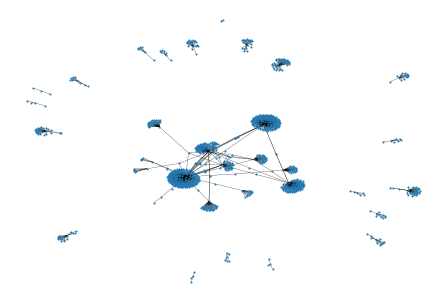

In [57]:

def myLoadGraph(filePath,directed):
    if directed:
        g = nx.DiGraph()
    else:
        g = nx.Graph()
    
    userEdgeList=pd.read_csv(filePath+"SampleEdge.csv")
    EdgeList=[]
        
    for i in range(len(userEdgeList)):
      
    
      EdgeList.append((userEdgeList.iloc[i][1],userEdgeList.iloc[i][2],{"weight":1}))
    
    g.add_edges_from(EdgeList)
    userNodeList=pd.read_csv(filePath+"SampleNode.csv")['Nodes']
    
    g.add_nodes_from(np.unique(userNodeList))
    
    return g,userNodeList






g,NodeList=myLoadGraph("https://storage.googleapis.com/aldrichstorage/yelp/smaller/",directed)


nx.write_gexf(g, "origraph.gexf") 
k=nx.read_gexf("origraph.gexf") 
print('number of nodes',k.number_of_nodes())
print('number of edges',k.number_of_edges())
nx.draw(k,node_size=1,width=0.25)


In [58]:
def transitionProbability(g, directed = False, p=1, q=1):
    aliasNodes, aliasEdges = {}, {};
    for node in g.nodes():
        probability = [g[node][nei]['weight'] for nei in sorted(g.neighbors(node))]
        norm_const = sum(probability)
        norm_probability = [float(prob)/norm_const for prob in probability]
        aliasNodes[node] = aliasSetup(norm_probability)

    if directed:
        for edge in g.edges():
            aliasEdges[edge] = edgesAliasSampling(g, edge[0], edge[1], p, q)
          
    else:
        for edge in g.edges():
            aliasEdges[edge] = edgesAliasSampling(g, edge[0], edge[1], p, q)
            aliasEdges[(edge[1], edge[0])] = edgesAliasSampling(g, edge[1], edge[0], p, q)

    return aliasNodes, aliasEdges


def edgesAliasSampling(g, src, dest, p=1, q=1):
    probability = [];
    for nei in sorted(g.neighbors(dest)):
        w=g[dest][nei]['weight']
        if nei==src:  # d_tx == 0
            probability.append(w/p)
        elif g.has_edge(nei, src):  # d_tx == 1
            probability.append(w)
        else:  # d_tx >==2
            probability.append(w/q)
    normProbability = [float(prob)/sum(probability) for prob in probability]
    return aliasSetup(normProbability)



def aliasSetup(probabilities):
    K = len(probabilities)
    q = np.zeros(K)
    J = np.zeros(K, dtype=np.int)
    smaller = []
    larger = []
    for kk, prob in enumerate(probabilities):
        q[kk] = K*prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)

    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] + q[small] - 1.0
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q



def node2vec(g, start, aliasNodes, aliasEdges, walk_length=3):
    path = [str(start)]
    while len(path)<walk_length:
        
        node = path[-1]
      
        neis = sorted(g.neighbors(node))
        if len(neis)>0:
            if len(path)==1:
                l = len(aliasNodes[node][0])
                idx = int(np.floor(np.random.rand()*l))
                if np.random.rand()<aliasNodes[node][1][idx]:
                    path.append(str(neis[idx]))
                else:
                    path.append(str(neis[aliasNodes[node][0][idx]]))
            else:
                prev = path[-2]
                l = len(aliasEdges[(prev, node)][0])
                idx = int(np.floor(np.random.rand()*l))
                if np.random.rand()<aliasEdges[(prev, node)][1][idx]:
                    path.append(str(neis[idx]))
                else:
                    path.append(str(neis[aliasEdges[(prev, node)][0][idx]]))
        else:
            break
    return path 





In [65]:


aliasNodes, aliasEdges = transitionProbability(g, directed,p,q)


walks = []
idx_total = []
walkLength=[]
for i in range(num_walks):
    r = np.array(range(len(NodeList)))
    np.random.shuffle(r)
   
    for node in [NodeList[j] for j in r]:
        walks.append(node2vec(g, node, aliasNodes, aliasEdges, walk_length))
    walkLength.append(len(walks[i]))
  



In [60]:
with open('walks.txt', 'w') as f:
    for walk in walks:
        for text in walk:
#             print(text)
        
            f.write("%s," % text)
        f.write("\n")
   

In [61]:
newWalks=[]
Allnode=[]
with open('walks.txt', 'r') as f:

    lines=f.readlines()
    
    for line in lines:
        
        line_split = line.split(",")
        for each in line_split :
            Allnode.append(each)
        newWalks.append(line_split[:-1])
print(len(np.unique(Allnode)))

986


In [63]:
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

model = Word2Vec(newWalks, size=200, min_count=0, sg=1, iter=5,compute_loss=True)
model.save('outputNode2Vec.model')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


985


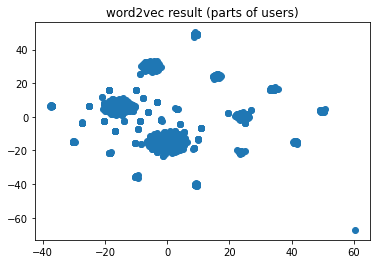

In [64]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

vocab = list(model.wv.vocab)

X = model[vocab]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
df = pd.DataFrame(X_tsne, columns=['x', 'y'])

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_title("word2vec result (parts of users)")
ax.scatter(df['x'], df['y'])
print(len(df['x']))
for word, pos in df.iterrows():
    ax.annotate(_,pos)